In [2]:
# import libraries to read & save into pandas
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np

def get_HTML(url):
    req = urllib2.Request(url, headers={ 'User-Agent': 'Mozilla/5.0' })
    html = urllib2.urlopen(req).read()
    soup = BeautifulSoup(html, 'html.parser')
    return soup

# function to get all links from an ITU webpage
def get_links(url):
    web = get_HTML(url)
    all_links = []
    # disregard links related to ITU non-English webpages, files & external websites (e.g. facebook, twitter,etc.) 
    # They are beyond the scope of this study
    lang = ["/fr/","/ar/","/es/","/ru/","/zh/","lang=fr","lang=ar", "lang=es","lang=ru","lang=zh", "twitter","facebook",
            "youtube","flickr","plus.google","linkedin","wordpress",".exe",".zip",".pdf",".PDF",".gif","addtocalendar"]
    links = web.find_all("a")
    for link in links:
        if link.has_attr('href'):
            if not any(x in link["href"] for x in lang) and link["href"].startswith("/"):
                if "//www.itu.int" in link["href"]:
                    all_links.append(link['href'].replace("//www.itu.int",""))
                else:
                    all_links.append(link['href'])
    # remove repeated links
    all_links = list(set(all_links))
    # remove self-references
    if "/en/" in all_links:
        all_links.remove("/en/")
    if "/" in all_links:
        all_links.remove("/")
    return(all_links)

In [2]:
# Start by getting the links from the ITU homepage
itu_web = "http://www.itu.int/en/Pages/default.aspx" # ITU home page in English
all_links = get_links(itu_web)
# keep track visited pages
visited = []
visited.append("/en/")
# create data frame and store links
df_links = pd.DataFrame(columns=["id","parent","depth","link"])
df_links["link"] = all_links
df_links["id"] = df_links.index
df_links["depth"] = 1
df_links["parent"] = -1 # i.e. no parent

In [4]:
depth1 = len(df_links)

# iterate over all websites 1 click away from the homepage
for i in range(depth1):
    # check that we have not visited the webpage before
    if df_links.link[i] not in visited:
        # get new links
        all_links = get_links("http://www.itu.int"+df_links.link[i])
        # append to data frame indicating parent and depth
        df_tmp = pd.DataFrame(columns=["link"])
        df_tmp.link = all_links
        len1 = len(df_links)
        df_links = df_links.append(df_tmp, ignore_index=True)
        df_links.id[len1:len(df_links)] = df_links[len1:len(df_links)].index
        df_links.depth[len1:len(df_links)] = 2
        df_links.parent[len1:len(df_links)] = df_links.id[i]
        # mark webpage as visited
        visited.append(df_links.link[i])


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
df_links2 = df_links.copy()

In [7]:
import traceback
import timeit
depth2 = np.where(df_links.depth==2)[0]
broken_links = []

# add timeout controls to avoid spending too much time scraping a single webpage
# controls work in UNIX/LINUX, may not work in other platforms, e.g. Windows
import signal
import time
class TimeoutException(Exception):   # Custom exception class
    pass
def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException
signal.signal(signal.SIGALRM, timeout_handler)


# iterate over all websites 2 clicks away from the homepage
for i in depth2:
    # check that we have not visited the webpage before
    if df_links.link[i] not in visited:
        # get new links
        start_time = timeit.default_timer()
        signal.alarm(5) # maximum of 5s to scrape a single page
        try:
            all_links = get_links("http://www.itu.int"+df_links.link[i])
        except urllib2.HTTPError:
            broken_links.append(df_links.link[i])
            visited.append(df_links.link[i])
            print("%d || %s || BROKEN LINK" %(i,df_links.link[i]))    
        except TimeoutException:
            broken_links.append(df_links.link[i])
            visited.append(df_links.link[i])
            print("%d || %s || TIMED OUT" %(i,df_links.link[i]))    
            continue
        except Exception as e:
            print e.__doc__
            print e.message
            traceback.print_exc()
            broken_links.append(df_links.link[i])
        else:
            # append to data frame indicating parent and depth
            df_tmp = pd.DataFrame(columns=["link"])
            df_tmp.link = all_links
            len1 = len(df_links)
            df_links = df_links.append(df_tmp, ignore_index=True)
            df_links.id[len1:len(df_links)] = df_links[len1:len(df_links)].index
            df_links.depth[len1:len(df_links)] = 3
            df_links.parent[len1:len(df_links)] = df_links.id[i]
            # mark webpage as visited
            visited.append(df_links.link[i])
            elapsed = timeit.default_timer() - start_time
            print("%d || %s || SCRAPED: %fs" %(i,df_links.link[i],elapsed))
        finally:
            signal.alarm(0)


60 || /en/history/Pages/FocusOnITUAreasOfWork.aspx || SCRAPED: 1.640949s
67 || /en/history/Pages/DigitalCollections.aspx || SCRAPED: 0.854054s
74 || /en/history/Pages/DiscoverITUsHistory.aspx || SCRAPED: 0.707668s
83 || /en/join/Pages/benefits.aspx || SCRAPED: 0.866358s
86 || /en/about/Pages/whatwedo.aspx || SCRAPED: 0.677309s
95 || /en/history/Pages/ITUsHistory.aspx || SCRAPED: 0.742919s
97 || /en/about/Pages/overview.aspx || SCRAPED: 0.588744s
100 || /en/about/Pages/vision.aspx || SCRAPED: 0.545120s
106 || /en/council/2017/Pages/speech-spina.aspx || SCRAPED: 0.694454s
107 || /en/council/CWG-SFP-2020-2023/Pages/default.aspx || SCRAPED: 0.545710s

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



108 || /en/council/2017/Documents/C17-new-delegates-briefing-en.pptx || SCRAPED: 3.224740s
109 || /en/council/2016/Pages/default.aspx || SCRAPED: 0.999390s
114 || /md/meetingdoc.asp?parent=S17-CL-C&destination=COM || SCRAPED: 0.749646s
116 || /en/delegates-corner/Pages/default.aspx || SCRAPED: 1.394842s
117 || /md/S17-DM-CIR-01002/en || SCRAPED: 0.433063s
118 || /md/S17-SG-CIR-0015/en || SCRAPED: 0.427912s
119 || /md/S16-CL-C-0129/en || SCRAPED: 0.433290s
120 || /net4/Search/BasicTexts || BROKEN LINK
121 || /en/osg/speeches/Pages/2017-05-15.aspx || SCRAPED: 0.859811s
122 || /en/council/Pages/proposed-VC.aspx || SCRAPED: 0.712857s
123 || /md/S17-DM-CIR-01001/en || SCRAPED: 0.439695s
124 || /en/council/Pages/default.aspx || SCRAPED: 1.425898s
125 || /en/council/2017/Pages/deadlines.aspx || SCRAPED: 0.771337s
129 || /en/council/Pages/practical-information.aspx || SCRAPED: 0.658978s
132 || /en/council/2017/ties/Documents/Visual-identity-Presentation-Council-24may2017.pptx || SCRAPED: 1.22


153 || /en/council/2017/Documents/C17-new-delegates-briefing-fr.pptx || SCRAPED: 3.426022s
154 || /home/feedback/index.phtml?mail=gbs || SCRAPED: 0.253346s
155 || /en/council/Pages/imac.aspx || SCRAPED: 0.669324s
156 || /en/council/Pages/documents.aspx || SCRAPED: 0.682631s
162 || /en/council/Pages/overview.aspx || SCRAPED: 0.594522s
163 || /en/council/Pages/groups.aspx || SCRAPED: 0.600240s
222 || /en/events/Pages/Calendar-Events.aspx?sector=ITU-SG || SCRAPED: 0.930971s
224 || /en/general-secretariat/Pages/osg.aspx || SCRAPED: 0.725111s
225 || /en/osg/dsg/Pages/default.aspx || SCRAPED: 1.046176s
226 || /en/publications/gs/Pages/default.aspx || SCRAPED: 3.360348s
228 || /en/general-secretariat/Pages/departments.aspx || SCRAPED: 0.640183s
242 || /en/ITU-R/information/events/webcast-public/Pages/WRC-Archives.aspx || SCRAPED: 0.927021s
243 || /en/ITU-R/study-groups || SCRAPED: 0.865324s
245 || /md/s15-sg-cir-0002/en || SCRAPED: 0.488420s
246 || /en/ITU-R/information/events/captioning/Pag

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:37: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6
Traceback (most recent call last):
  File "<ipython-input-7-3e57b7da2a04>", line 25, in <module>
    all_links = get_links("http://www.itu.int"+df_links.link[i])
  File "<ipython-input-1-649c105302c3>", line 15, in get_links
    web = get_HTML(url)
  File "<ipython-input-1-649c105302c3>", line 9, in get_HTML
    html = urllib2.urlopen(req).read()
  File "/usr/lib/python2.7/urllib2.py", line 127, in urlopen
    return _opener.open(url, data, timeout)
  File "/usr/lib/python2.7/urllib2.py", line 402, in open
    req = meth(req)
  File "/usr/lib/python2.7/urllib2.py", line 1113, in do_request_
    raise URLError('no host given')
URLError: <urlopen error no host given>



1388 || /en/ITU-T/wtsa16/Documents/CPI/ITU-T_Res2_2016-E.docx || SCRAPED: 0.657306s
1389 || /en/ITU-T/wtsa16/Pages/As-Received.aspx || SCRAPED: 1.022008s
1390 || /en/ITU-T/wtsa16/Pages/candidates.aspx || SCRAPED: 0.644855s
1393 || /md/T13-TSB-CIR-0230/en || SCRAPED: 0.495037s
1394 || /en/ITU-T/wtsa16/Pages/CxO-201610.aspx || SCRAPED: 0.578854s
1395 || /en/ITU-T/wtsa16/Pages/Fellowship.aspx || SCRAPED: 0.697973s
1396 || /TIES || SCRAPED: 0.566963s
1397 || /en/ITU-T/wtsa16/Pages/FAQ.aspx || SCRAPED: 0.764547s
1398 || /en/ITU-T/wtsa16/gss/Pages/default.aspx || SCRAPED: 1.082541s


1399 || /en/ITU-T/wtsa16/Documents/CPI/ITU-T_Res2_2016-S.DOCX || SCRAPED: 0.565055s
1401 || /publications || SCRAPED: 1.003425s


1403 || /en/ITU-T/wtsa16/Documents/CPI/ITU-T_Res2_2016-F.DOCX || SCRAPED: 0.571472s
1404 || /net4/proposals/WTSA16 || TIMED OUT
1409 || /en/ITU-T/wtsa16/Pages/information.aspx#transfers || SCRAPED: 0.361000s
1411 || /md/T13-WTSA.16-161025-TD-GEN-0003/en || SCRAPED: 0.425415s


1413 || /en/ITU-T/wtsa16/Documents/CPI/ITU-T_Res2_2016-A.DOCX || SCRAPED: 0.776145s
1414 || /en/newsroom/accreditation/Pages/wtsa-2016.aspx || SCRAPED: 0.759039s


1415 || /en/ITU-T/wtsa16/Documents/CPI/ITU-T_Res2_2016-R.DOCX || SCRAPED: 0.674631s
1417 || /md/T13-WTSA.16-C/en || SCRAPED: 0.746130s
1418 || /en/ITU-T/wtsa16/prepmeet/Pages/default.aspx || SCRAPED: 0.904169s
1419 || /en/ITU-T/wtsa12/Pages/default.aspx || SCRAPED: 0.860921s


1420 || /en/ITU-T/wtsa16/Documents/CPI/ITU-T_Res2_2016-C.DOCX || SCRAPED: 0.706915s
1421 || /ITU-T/wtsa-08 || SCRAPED: 0.456248s
1423 || /online/regsys/TIES/auth/ITU-T/edrs.focalpoint?_eventid=3000899 || BROKEN LINK
1424 || /en/ITU-T/wise/Pages/WTSA-16-WISE-Event.aspx || SCRAPED: 1.002776s
1426 || /en/ITU-T/wtsa16/Pages/syncdocs.aspx || SCRAPED: 0.760499s
1427 || /en/ITU-T/wtsa16/Pages/information.aspx || SCRAPED: 0.342917s
1429 || /en/wcit-12old/Pages/briefing-sessions.aspx || SCRAPED: 1.013206s
1430 || /md/T13-WTSA.16/new/en || SCRAPED: 0.551923s
1431 || /md/T13-WTSA.16-161025-TD/en || SCRAPED: 0.852028s
1434 || /en/ITU-T/60/Pages/default.aspx || SCRAPED: 0.905287s
1435 || /en/ITU-T/wtsa16/Pages/invitation-letters.aspx || SCRAPED: 0.581497s
1436 || /pub/T-REG-LIV.1-2016/en || SCRAPED: 2.093670s
1438 || /en/newsroom/wtsa-16/Pages/default.aspx || SCRAPED: 0.992497s
1439 || /en/ITU-T/wtsa16/Pages/documents.aspx || SCRAPED: 0.619702s
1441 || /en/ITU-T/wtsa16/Pages/structure.aspx || SCRA

In [31]:
df_links.to_csv("ITU_links.csv", sep='\t', encoding='utf-8', header=True)

In [3]:
ITU_links = pd.read_csv("ITU_links.csv",sep='\t', encoding='utf-8', index_col=0)

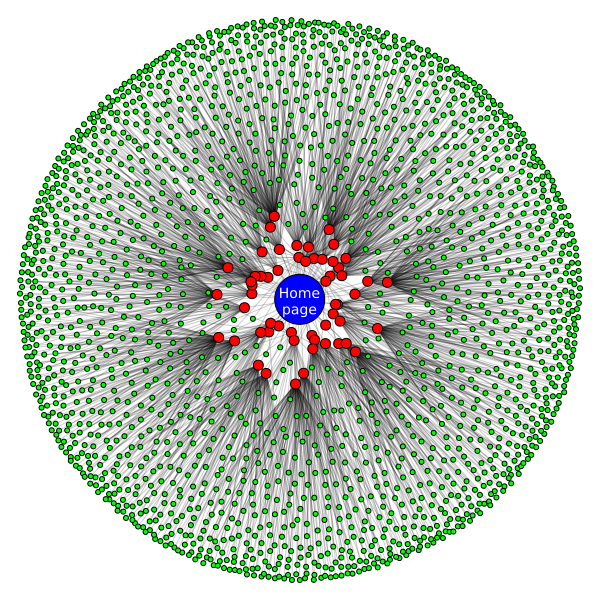

In [56]:
import igraph as ig # requires igraph: sudo pip install python-igraph 
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

## PLOT GRAPH ALL ITU WEBPAGES UP TO DEPTH 3
links = []
colors = []
sizes = []

# BUILD LIST OF EDGES & NODES
# initial node properties (ITU Home page)
colors.append("blue")
sizes.append(50)
#subsequent nodes/links
for row in ITU_links.itertuples():
    if row[1]<3:
        links.append((int(row[4])+1,int(row[2])+1))
        if row[1] == 1:
            colors.append("red")
            sizes.append(10)
        elif row[1] == 2:
            colors.append("green")
            sizes.append(5)
nodes = list(range(len(links)+1))

# CREATE GRAPH
g = ig.Graph()
g.add_vertices(len(nodes))
g.add_edges(links)
g.vs['color']=colors
g.vs['size']=sizes
random.seed(100)
layout = g.layout("kk")
g.vs[0]['label']="Home\npage"
g.vs[0]['label_color']="white"
# ensure no overlapping with initial node
for i, dot in enumerate(layout):
    if i != 0 and abs(dot[0]-layout[0][0]) < 0.3 and abs(dot[1]-layout[0][1]) < 0.3:
        k=min(abs(0.4/(0.01+dot[0]-layout[0][0])),
                 abs((0.4/(0.01+dot[1]-layout[0][1]))))
        layout[i] = list([layout[0][0]+k*(dot[0]-layout[0][0]),layout[0][1]+k*(dot[1]-layout[0][1])])


# PRINT & SAVE
ig.plot(g, "ITU_links_graph.pdf", layout = layout, edge_color="rgba(1,1,1,0.2)")
ig.plot(g, "ITU_links_graph.svg", layout = layout, edge_color="rgba(1,1,1,0.2)")
ig.plot(g, "ITU_links_graph.png", layout = layout, edge_color="rgba(1,1,1,0.2)")


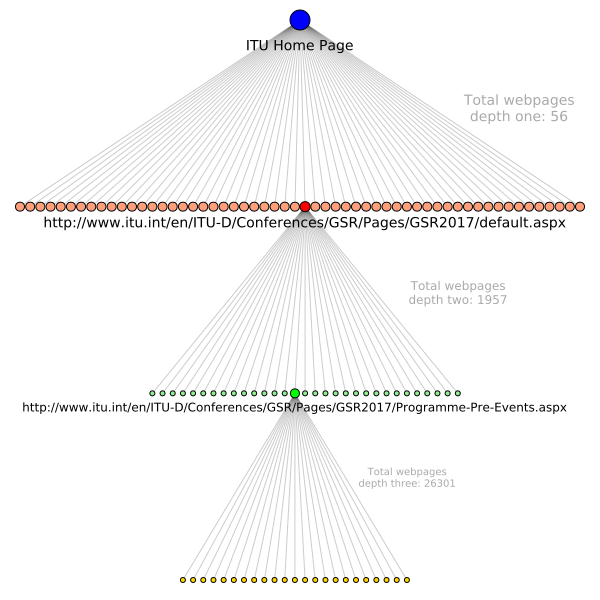

In [59]:
import igraph as ig # requires igraph: sudo pip install python-igraph 
import matplotlib.pyplot as plt
import random
#%matplotlib inline

## PLOT DEPTH-FIRST SEARCH PATH UP TO DEPTH 4
links = []
colors = []
sizes = []

# BUILD LIST OF EDGES & NODES
# initial node properties (ITU Home page)
colors.append("blue")
sizes.append(20)
#subsequent nodes/links
for row in ITU_links.itertuples():
    if (row[4]==-1 or row[4]==28 or row[4]==1061):
        if row[1] == 1:
            links.append((int(row[4])+1,int(row[2])+1))
            colors.append("Light Salmon")
            sizes.append(9)
        elif row[1] == 2:
            links.append((int(row[4])+1,int(row[2])+1-991))
            colors.append("Light Green")
            sizes.append(5)
        elif row[1] == 3:
            links.append((int(row[4])+1-991,int(row[2])+1-19696))
            colors.append("Gold")
            sizes.append(5)  
nodes = list(range(len(links)+1))

# CREATE GRAPH
g = ig.Graph()
g.add_vertices(len(nodes))
g.add_edges(links)
g.vs['color']=colors
g.vs['size']=sizes
# add labels
g.vs[0]['label']="ITU Home Page"
g.vs[0]['label_dist']=2
g.vs[29]['color']="red"
g.vs[29]['size']=10
g.vs[29]['label']="http://www.itu.int" + str(ITU_links.loc[ITU_links['id'] == 28].iloc[0,2])
g.vs[29]['label_dist']=2
g.vs[50]['label']="Total webpages \n depth one: " + str(ITU_links.loc[ITU_links['depth']==1].shape[0])
g.vs[50]['label_dist']=-25
g.vs[50]['label_color']="Dark Gray"
g.vs[71]['color']="green"
g.vs[71]['size']=9
g.vs[71]['label_size']=12
g.vs[71]['label']="http://www.itu.int" + str(ITU_links.loc[ITU_links['id'] == 1061].iloc[0,2])
g.vs[71]['label_dist']=2
g.vs[87]['label']="Total webpages \n depth two: " + str(ITU_links.loc[ITU_links['depth']==2].shape[0])
g.vs[87]['label_dist']=-45
g.vs[87]['label_size']=12
g.vs[87]['label_color']="Dark Gray"
g.vs[110]['label']="Total webpages \n depth three: " + str(ITU_links.loc[ITU_links['depth']==3].shape[0])
g.vs[110]['label_dist']=-45
g.vs[110]['label_size']=10
g.vs[110]['label_color']="Dark Gray"

random.seed(1)
#layout = g.layout("graphopt",spring_length=0,spring_constant=0.65,node_mass=25)
layout=g.layout("tree")
# PRINT & SAVE
ig.plot(g, "ITU_links_layers.pdf", layout = layout, edge_color="rgba(1,1,1,0.2)")
ig.plot(g, "ITU_links_layers.png", layout = layout, edge_color="rgba(1,1,1,0.2)")
ig.plot(g, "ITU_links_layers.svg", layout = layout, edge_color="rgba(1,1,1,0.2)")


In [30]:
# GET TEXT OF EACH WEBPAGE

import re, bs4
def visible(element):
    if element.parent.name in ['style', 'script', '[document]', 'head', 'title']:
        return False
    elif isinstance(element,bs4.element.Comment):
        return False
    elif len(element) < 10:
        return False
    return True

ITU_links["Text"] = ""

# GET FIRST TEXT WEBSITES 1 CLICK AWAY FROM ITU HOMEPAGE
for i in range(56):
    url = "http://www.itu.int" + str(ITU_links.ix[i,2])
    web = get_HTML(url)
    text = web.findAll(text=True)
    visible_text = filter(visible, text)
    visible_text = [j.strip() for j in visible_text]
    visible_text = [s for s in visible_text if len(s) > 10 and "Page Content" not in s]
    s = ' '.join(visible_text)
    ITU_links.ix[i,4] = re.sub(r' [^a-z0-9]+ ', ' ',s.encode('ascii','ignore'))

In [38]:
# GET TEXT WEBSITES 2 CLICKS AWAY FROM ITU HOMEPAGE

depth2 = ITU_links.ix[ITU_links["depth"]==2,:].shape[0]

# add timeout controls to avoid spending too much time scraping a single webpage
# controls work in UNIX/LINUX, may not work in other platforms, e.g. Windows
import traceback
import timeit
broken_links = []
import signal
import time
class TimeoutException(Exception):   # Custom exception class
    pass
def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException
signal.signal(signal.SIGALRM, timeout_handler)


for i in range(depth2):
    # get new text
        start_time = timeit.default_timer()
        signal.alarm(5) # maximum of 5s to scrape a single page
        try:
            url = "http://www.itu.int" + str(ITU_links.ix[56+i,2])
            web = get_HTML(url)
        except urllib2.HTTPError:
            broken_links.append(url)
            print("%d || %s || BROKEN LINK" %(i,url))    
        except TimeoutException:
            broken_links.append(url)
            print("%d || %s || TIMED OUT" %(i,url))    
            continue
        except Exception as e:
            print e.__doc__
            print e.message
            traceback.print_exc()
            broken_links.append(url)
        else:
            # append to data frame indicating parent and depth
            text = web.findAll(text=True)
            visible_text = filter(visible, text)
            visible_text = [j.strip() for j in visible_text]
            visible_text = [s for s in visible_text if len(s) > 10 and "Page Content" not in s]
            s = ' '.join(visible_text)
            ITU_links.ix[56+i,4] = re.sub(r' [^a-z0-9]+ ', ' ',s.encode('ascii','ignore'))
            elapsed = timeit.default_timer() - start_time
            print("%d || %s || SCRAPED: %fs" %(i,url,elapsed))
        finally:
            signal.alarm(0)

    

0 || http://www.itu.int/home/contact/index.html || SCRAPED: 0.659867s
1 || http://www.itu.int/en/general-secretariat/Pages/default.aspx || SCRAPED: 0.631225s
2 || http://www.itu.int/en/ITU-D || SCRAPED: 0.833107s
3 || http://www.itu.int/en/ITU-D/Statistics || SCRAPED: 0.994426s
4 || http://www.itu.int/en/history/Pages/FocusOnITUAreasOfWork.aspx || SCRAPED: 0.817022s
5 || http://www.itu.int/en/events || SCRAPED: 0.819138s
6 || http://www.itu.int/en/ITU-D/Pages/Regional-Presence.aspx || SCRAPED: 0.604403s
7 || http://www.itu.int/en/mediacentre/Pages/default.aspx || SCRAPED: 1.213102s
8 || http://www.itu.int/en/Pages/accessibility.aspx || SCRAPED: 0.314398s
9 || http://www.itu.int/en/ITU-R/Pages/default.aspx || SCRAPED: 3.040232s
10 || http://www.itu.int/en/ITU-T/Pages/default.aspx || SCRAPED: 0.711808s
11 || http://www.itu.int/en/history/Pages/DigitalCollections.aspx || SCRAPED: 0.795450s
12 || http://www.itu.int/en/about || SCRAPED: 0.781704s
13 || http://www.itu.int/en/membership || SC

No handlers could be found for logger "bs4.dammit"


52 || http://www.itu.int/en/council/2017/Documents/C17-new-delegates-briefing-en.pptx || SCRAPED: 1.037634s
53 || http://www.itu.int/en/council/2016/Pages/default.aspx || SCRAPED: 1.151074s
54 || http://www.itu.int/en/annual-report-2016/Pages/default.aspx || SCRAPED: 1.052846s
55 || http://www.itu.int/en/general-secretariat/Pages/default.aspx || SCRAPED: 0.582404s
56 || http://www.itu.int/en/ITU-D || SCRAPED: 0.917292s
57 || http://www.itu.int/pub/S-CONF-PLEN-2015 || SCRAPED: 1.592012s
58 || http://www.itu.int/md/meetingdoc.asp?parent=S17-CL-C&destination=COM || SCRAPED: 0.622192s
59 || http://www.itu.int/en/ITU-D/Statistics || SCRAPED: 0.361709s
60 || http://www.itu.int/en/delegates-corner/Pages/default.aspx || SCRAPED: 0.731813s
61 || http://www.itu.int/md/S17-DM-CIR-01002/en || SCRAPED: 0.398058s
62 || http://www.itu.int/md/S17-SG-CIR-0015/en || SCRAPED: 0.408455s
63 || http://www.itu.int/md/S16-CL-C-0129/en || SCRAPED: 0.396757s
64 || http://www.itu.int/net4/Search/BasicTexts || BR

Traceback (most recent call last):
  File "<ipython-input-38-4052137d14e1>", line 25, in <module>
    web = get_HTML(url)
  File "<ipython-input-2-649c105302c3>", line 9, in get_HTML
    html = urllib2.urlopen(req).read()
  File "/usr/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/usr/lib/python2.7/urllib2.py", line 429, in open
    req = meth(req)
  File "/usr/lib/python2.7/urllib2.py", line 1125, in do_request_
    raise URLError('no host given')
URLError: <urlopen error no host given>


387 || http://www.itu.int/en/publications/ITU-D/Pages/D-LDC.aspx || SCRAPED: 4.384668s
388 || http://www.itu.int/en/Pages/default.aspx || SCRAPED: 0.314227s
389 || http://www.itu.int/en/general-secretariat/Pages/default.aspx || SCRAPED: 0.312276s
390 || http://www.itu.int/en/ITU-D || SCRAPED: 0.442214s
391 || http://www.itu.int/en/ITU-D/Statistics || SCRAPED: 0.382583s
392 || http://www.itu.int/en/events || SCRAPED: 0.862216s
393 || http://www.itu.int/en/ITU-D/Pages/Regional-Presence.aspx || SCRAPED: 0.811497s
394 || http://www.itu.int/en/mediacentre/Pages/default.aspx || SCRAPED: 1.301547s
395 || http://www.itu.int/en/Pages/accessibility.aspx || SCRAPED: 0.371256s
396 || http://www.itu.int/en/ITU-R/Pages/default.aspx || TIMED OUT
397 || http://www.itu.int/en/ITU-T/Pages/default.aspx || SCRAPED: 0.324917s
398 || http://www.itu.int/en/about || SCRAPED: 0.390353s
399 || http://www.itu.int/en/membership || SCRAPED: 0.403448s
400 || http://www.itu.int/en/publications || SCRAPED: 1.187434s


In [42]:
# WE COULD GET THE SAME WAY THE TEXT OF WEBSITES 3 CLICKS AWAY
# NOT DONE BECAUSE IT WOULD BE TIME CONSUMING (26'000 webpages * aprox 1s / webpage = more than 7h)
# AND IT IS NOT NECESSARY TO PROOF THE USEFULNESS OF THE APPROACH PROPOSED IN THIS PROJECT 

# SAVE FILES: ALL WEBPAGES AND THOSE WITH A MINIMUM OF TEXT
ITU_links.to_csv("ITU_links_all.csv", sep='\t', encoding='utf-8', header=True)

ITU_links_withText = ITU_links[ITU_links['Text'].str.len() > 40]
ITU_links_withText.to_csv("ITU_links_text.csv", sep='\t', encoding='utf-8', header=True)